# Video analysis


## Setting
 - Auto Reload
 - path for utils

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys, os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [6]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [7]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid

## 2. LLM 정의

In [8]:
from utils.bedrock import bedrock_model
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [9]:
llm = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Nova-Pro-CRI"),
    #model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-V-2-Sonnet-CRI"),
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 1024,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
        #'topP': ...,
    }
    #additional_model_request_fields={"top_k": 200}
)

## 3. Analysis

### 3.1 LLM caller 정의

In [10]:
from textwrap import dedent
from utils.bedrock import bedrock_utils, bedrock_chain

class llm_call():

    def __init__(self, **kwargs):

        self.llm=kwargs["llm"]
        self.verbose = kwargs.get("verbose", False)
        self.chain = bedrock_chain(bedrock_utils.converse_api) | bedrock_chain(bedrock_utils.outputparser)

    def _message_format(self, role, message):

        if role == "user":
             message_format = {
                "role": "user",
                "content": [{"text": dedent(message)}]
            }
        elif role == "assistant":
            
            message_format = {
                "role": "assistant",
                'content': [{'text': dedent(message)}]
            }

        return message_format
            
    def invoke(self, **kwargs):

        system_prompts = kwargs.get("system_prompts", None)
        messages = kwargs["messages"]
        #llm_name = kwargs["llm_name"]
    
        response = self.chain( ## pipeline의 제일 처음 func의 argument를 입력으로 한다. 여기서는 converse_api의 arg를 쓴다.
            llm=self.llm,
            system_prompts=system_prompts,
            messages=messages,
            verbose=self.verbose
        )
        
        ai_message = self._message_format(role="assistant", message=response["text"])
        messages.append(ai_message)
        return response, messages

### 3.2 Timer 정의

In [11]:
import time

In [12]:
class TimeMeasurement:
    def __init__(self):
        self.start_time = None
        self.measurements = {}

    def start(self):
        self.start_time = time.time()

    def measure(self, section_name):
        if self.start_time is None:
            raise ValueError("start() 메서드를 먼저 호출해야 합니다.")
        
        end_time = time.time()
        elapsed_time = end_time - self.start_time
        self.measurements[section_name] = elapsed_time
        self.start_time = end_time  # 다음 구간 측정을 위해 시작 시간 재설정

    def reset(self, ):
        self.measurements = {}

    def print_measurements(self):
        for section, elapsed_time in self.measurements.items():
            #print(f"{section}: {elapsed_time:.5f} 초")
            print(colored (f"\nelapsed time: {section}: {elapsed_time:.5f} 초", "red"))

### 3.3 Video analyzer 정의

In [13]:
import cv2
import shutil
import pickle
import botocore

from pathlib import Path
from pprint import pprint
from typing import TypedDict, Any
import matplotlib.pyplot as plt
from utils.common_utils import retry
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

In [14]:
class GraphState(TypedDict):
    video_path: str
    video_info: dict
    analysis_config: dict
    summary:str
    target_apps: list[str]
    ask_refo: str
    code: str
    code_err: str
    img_path: str
    img_bytes: str
    chart_desc: str
    prev_node: str

- **approach 1**: 각각의 프레임에 대한 desc를 생성한 후, 생성된 desc를 모아서 요약하여 상황설명 한다.

In [15]:
class video_analyzer():

    def __init__(self, **kwargs):

        self.llm=kwargs["llm"]
        self.state = GraphState

        self.llm_caller = llm_call(
            llm=self.llm,
            verbose=True ## To show token usage
        ) 

        self._graph_definition()
        self.messages = []
        self.img_bytes = ""
        
        self.timer = TimeMeasurement()
        
    def _get_price(self, tokens):
        
        input_price = tokens["input"] * 0.0008 / 1000
        output_price = tokens["output"] * 0.0032 / 1000
        total = input_price + output_price
        
        print ("======= Cost Calculator =======")
        print (f'Token Usage, input: {tokens["input"]}, Output: {tokens["output"]}')
        print (f'Price: {total} USD')
        print ("===============================")
        
    def _get_string_from_message(self, message):
        return message["content"][0]["text"]
    
    def _get_message_from_string(self, role, string, imgs=None):
        
        message = {
            "role": role,
            "content": []
        }
        
        if imgs is not None:
            for img in imgs:
                img_message = {
                    "image": {
                        "format": 'png',
                        "source": {"bytes": img}
                    }
                }
                message["content"].append(img_message)
        
        message["content"].append({"text": dedent(string)})

        return message
        
    def _frame_to_bytes(self, frame, format='.png'):
        """
        cv2 frame을 bytes로 변환

        Args:
            frame: cv2로 읽은 이미지/프레임
            format: 이미지 포맷 (예: '.jpg', '.png')

        Returns:
            bytes: 이미지의 바이트 데이터
        """
        # imencode() 함수로 프레임을 지정된 포맷의 이미지로 인코딩
        # 반환값: (success, encoded_image)
        success, buffer = cv2.imencode(format, frame)

        if not success:
            raise ValueError("이미지 인코딩 실패")

        # numpy array를 bytes로 변환
        return buffer.tobytes()

    def _save_pickle(self, data: Any, file_path: str | Path) -> None:
        """
        데이터를 pickle 파일로 저장합니다.

        Args:
            data: 저장할 데이터 (Any type)
            file_path: 저장할 파일 경로 (확장자 .pkl 권장)
        """
        file_path = Path(file_path)

        # 디렉토리가 없으면 생성
        file_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            with open(file_path, 'wb') as f:
                pickle.dump(data, f)
            print(f"Successfully saved to {file_path}")
        except Exception as e:
            print(f"Error saving pickle file: {e}")

    def _load_pickle(self, file_path: str | Path) -> Any:
        """
        pickle 파일을 로드합니다.

        Args:
            file_path: 로드할 파일 경로

        Returns:
            저장된 데이터 객체

        Raises:
            FileNotFoundError: 파일이 존재하지 않을 경우
        """
        file_path = Path(file_path)

        if not file_path.exists():
            raise FileNotFoundError(f"No pickle file found at {file_path}")

        try:
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
            return data
        except Exception as e:
            print(f"Error loading pickle file: {e}")
            return None

    def get_messages(self, ):
        return self.messages
        
    def _graph_definition(self, **kwargs):
        
        def agent(state):
            
            self.timer.start()
            self.timer.reset()
            
            print("---CALL AGENT---")
            video_path = state["video_path"]
            analysis_config = state["analysis_config"]
            
            self.tokens = {"input": 0, "output": 0, "total": 0}
            self.pricing = {"input": 0, "output": 0}
            
            print (analysis_config)
 
            return self.state(
                video_path=video_path,
                analysis_config=analysis_config,
                rev_node="AGENT"
            )

        def sample_video_frames(state):
            
            def setup_directory(dir_path):
    
                print ("===setup_directory===")
                # 디렉토리가 존재하는지 확인
                if os.path.exists(dir_path):
                    # 존재하면 삭제
                    shutil.rmtree(dir_path)
                    print(f"기존 디렉토리 삭제됨: {dir_path}")

                # 디렉토리 생성
                os.makedirs(dir_path)
                print(f"디렉토리 생성됨: {dir_path}")
                print ("=====================")
    
            
            print("---SAMPLE VIDEO FRAMES---")
            
            video_path = state["video_path"]
            sample_msec = state["analysis_config"]["sample_msec"]
            resize_ratio = state["analysis_config"]["resize_ratio"]
            sample_output_dir = state["analysis_config"]["sample_output_dir"]
            
            
            print ("===sample_video_frames===")
            """
            비디오에서 특정 시간 간격으로 프레임을 샘플링하는 함수

            Args:
                video_path (str): 비디오 파일 경로
                sample_msec (int): 샘플링 간격 (밀리초)
                sample_output_dir (Optional[str]): 프레임 저장 디렉토리. None이면 저장하지 않음

            Returns:
                Tuple[int, int]: (총 프레임 수, 샘플링된 프레임 수)

            Raises:
                FileNotFoundError: 비디오 파일이 없는 경우
                ValueError: 샘플링 간격이 잘못된 경우
            """
            # 입력값 검증
            if not os.path.exists(video_path):
                raise FileNotFoundError(f"비디오 파일을 찾을 수 없습니다: {video_path}")

            if sample_msec <= 0:
                raise ValueError("샘플링 간격은 0보다 커야 합니다")

            # 비디오 캡처 객체 생성
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                raise RuntimeError("비디오 파일을 열 수 없습니다")

            # 비디오 정보 가져오기
            fps = cap.get(cv2.CAP_PROP_FPS)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # 샘플링 간격(프레임 단위) 계산
            frame_interval = max(1, int(sample_msec / 1000 * fps))

            # 출력 디렉토리 생성 (지정된 경우)
            if sample_output_dir is not None:
                setup_directory(sample_output_dir)

            sampled_count = 0
            frame_count = 0
            sampled_frame = {"frame": [], "seq": []}

            while True:
                ret, frame = cap.read()
                if not ret: break
                
                # resize
                if resize_ratio != 1:
                    re_width, re_height = int(frame.shape[1]*resize_ratio), int(frame.shape[0]*resize_ratio)
                    frame = cv2.resize(frame, (re_width, re_height), interpolation=cv2.INTER_AREA)

                # frame_interval마다 프레임 처리
                if frame_count % frame_interval == 0:
                    if sample_output_dir is not None:
                        # 프레임 저장
                        frame_path = os.path.join(sample_output_dir, f"frame_{frame_count:06d}.jpg")
                        cv2.imwrite(frame_path, frame)
                    sampled_count += 1
                    sampled_frame["frame"].append(frame)
                    sampled_frame["seq"].append(frame_count)
                frame_count += 1

                # 진행상황 출력 (10% 단위)
                if frame_count % (total_frames // 10) == 0:
                    progress = (frame_count / total_frames) * 100
                    print(f"진행률: {progress:.1f}%")

            # 자원 해제
            cap.release()

            print(f"\n처리 완료:")
            print(f"총 프레임 수: {total_frames}")
            print(f"프레임 크기: {sampled_frame['frame'][0].shape[1]}X{sampled_frame['frame'][0].shape[0]}")
            print(f"샘플링된 프레임 수: {sampled_count}")
            print(f"샘플링 간격: {frame_interval}프레임 ({sample_msec}ms)")
            if sample_output_dir is not None:
                print(f"저장 위치: {sample_output_dir}")

            print ("=========================")
            
            sampled_frames_path = os.path.join(sample_output_dir, "pickle", "sampled_frames.pickle")
            self._save_pickle(sampled_frame, sampled_frames_path)
            
            video_info = {
                "sampled_frames_path": sampled_frames_path,
                "total_frame_cnt": total_frames,
                "sampled_cnt": sampled_count
            }
            
            self.timer.measure("node: sample_video_frames")
            self.timer.print_measurements()
            
            return self.state(
                video_info=video_info,
                rev_node="SAMPLE_VIDEO_FRAMES"
            )
        
        def video_description(state):
            
            @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(botocore.exceptions.EventStreamError))
            def frame_description(**kwargs):

                sampled_frame = kwargs["sampled_frame"]
                sampled_frame_idx = kwargs["sampled_frame_idx"]
                total_frame_cnt = kwargs["total_frame_cnt"]
                prev_frame_desc = kwargs.get("prev_frame_desc", "None")
                messages = kwargs["messages"] 

                system_prompts = dedent(
                    '''
                    System:
                    1. You are a CCTV Video Analysis Expert specialized in analyzing surveillance footage frames and describing situations in natural language.
                    2. You must analyze the given CCTV frame images objectively and comprehensively.

                    Model Instructions:
                    - You MUST maintain objectivity in all observations
                    - You MUST describe only observable facts, avoiding speculation
                    - You MUST focus on moving objects and people activity, ignoring static elements                    
                    - You MUST write all descriptions in Korean
                    - You MUST consider the previous frame description for context
                    - You MUST highlight any significant changes or anomalies
                    - DO NOT describe stationary objects or background elements
                    - DO NOT make subjective interpretations
                    - DO NOT speculate about intentions or motivations
                    - DO NOT use ```json``` in response

                    Input Format:
                    - frame: Captured CCTV frame image
                    - frame_info:
                        - frame_number: Current frame number in sequence
                        - total_frame_number: Total number of frames
                        - prev_frame_desc: Description of previous frame

                    Output Schema:
                    {
                        "scene_description": string,  // Objective description of current frame situation
                        "person_description": string  // Distinctive features of moving persons for identification
                    }

                    Observation Guidelines:
                    1. Movement Analysis:
                       - Track position changes of people and objects
                       - Note entry/exit of subjects from frame
                       - Document any sudden or unusual movements

                    2. Visual Clarity:
                       - Report any visual obstructions
                       - Note lighting conditions affecting visibility
                       - Mention any quality issues impacting analysis

                    3. Subject Differentiation:
                       - Distinguish between multiple subjects
                       - Note identifying characteristics
                       - Track individual movements separately

                    4. Critical Observations:
                       - Highlight suspicious activities
                       - Note any safety concerns
                       - Document unusual patterns

                    Remember: Your descriptions must be concise, clear, and factual, focusing only on observable changes and movements within the frame.
                    '''
                )
                user_prompts = dedent(
                    '''
                    Frame_number:
                    {frame_number}
                    Total_frame_number:
                    {total_frame_number}
                    Prev_frame_desc:
                    {prev_frame_desc}

                    '''
                )

                img_bytes = self._frame_to_bytes(sampled_frame)
                system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)  

                context = {
                    "frame_number": sampled_frame_idx,
                    "total_frame_number": total_frame_cnt,
                    "prev_frame_desc": prev_frame_desc
                }
                user_prompts = user_prompts.format(**context)

                message = self._get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
                messages.append(message)
                
                 # 이미지 표시
                rgb_frame = cv2.cvtColor(sampled_frame, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(10, 6))
                plt.imshow(rgb_frame)
                plt.axis('off')  # 축 숨기기
                plt.show()
                
                # Call LLM
                resp, messages_updated = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
                
                if self.llm_caller.verbose:
                    self.tokens["input"] += resp["token_usage"]["inputTokens"]
                    self.tokens["output"] += resp["token_usage"]["outputTokens"]
                    self.tokens["total"] += resp["token_usage"]["totalTokens"]
                    print (f'total token usage: {self.tokens}')    
                
                messages = messages_updated
                results = eval(resp["text"])

                return results
            
            print("---VIDEO DESCRIPTION---")
            sampled_frames= self._load_pickle(state["video_info"]["sampled_frames_path"])
            total_frame_cnt=state["video_info"]["total_frame_cnt"]
            messages=kwargs.get("messages", [])

            frame_desc = "None"
            frame_descs = []
            for sampled_frame_idx, sampled_frame in zip(sampled_frames["seq"], sampled_frames["frame"]):

                res = frame_description(
                    sampled_frame=sampled_frame,
                    sampled_frame_idx=sampled_frame_idx,
                    total_frame_cnt=total_frame_cnt,
                    frame_desc=frame_desc,
                    messages=[]
                )
                frame_desc = res["scene_description"]
                frame_descs.append([res["scene_description"], res["person_description"]])

            system_prompts = dedent(
                '''
                System:
                1. You are an Advanced CCTV Analysis Expert specialized in synthesizing frame-by-frame descriptions to provide comprehensive situation analysis and event extraction, particularly for after-business-hours surveillance footage.
                2. Your role is to analyze sequential frame descriptions and identify meaningful patterns and events while maintaining privacy and security considerations.

                Model Instructions:
                1. Analysis Requirements:
                  - You MUST review frame descriptions chronologically
                  - You MUST identify and extract meaningful events
                  - You MUST write all content in Korean
                  - You MUST focus on behaviors, not person counts
                  - You MUST consider after-business-hours context when assessing behavior
                  - DO NOT include personally identifiable information
                  - DO NOT speculate about unclear situations
                  - DO NOT include routine movements as key events

                2. Event Assessment Criteria:
                  - Security risks
                  - Abnormal behavior patterns
                  - Property or facility risks
                  - Pattern repetition
                  - Contextual significance
                  - Unauthorized access or presence
                  - After-hours activity legitimacy

                Input Format:
                frame_descriptions: [
                   {
                       "scene_description": string,
                       "person_description": string
                   }
                ]

                Output Schema:
                {
                   "summary": string,  // Comprehensive situation analysis
                   "key_events": [
                       {
                           "description": string,  // Event description
                           "significance": "HIGH/MEDIUM/LOW"  // Event importance
                       }
                   ],
                   "objects_involved": {
                       "items": [string]    // Key objects
                   },
                   "analysis": {
                       "pattern": string,   // Identified behavior patterns
                       "anomalies": [string], // Unusual activities
                       "risk_assessment": string  // Potential risk evaluation
                   }
                }

                Analysis Guidelines:
                1. After-Hours Context Evaluation:
                  - Consider normal vs. abnormal after-hours presence
                  - Evaluate authorization level of observed personnel
                  - Pay special attention to access patterns
                  - Monitor unusual equipment or area usage

                2. Context Evaluation:
                  - Review descriptions chronologically
                  - Consider full context for pattern identification
                  - Verify consistency across frames
                  - Identify person consistency across frames

                3. Event Prioritization:
                  - Focus on security-relevant events
                  - Identify behavioral patterns
                  - Assess potential risks
                  - Exclude authorized routine activities
                  - Flag any unauthorized after-hours activities

                4. Risk Assessment:
                  - Evaluate security implications
                  - Identify potential threats
                  - Assess pattern abnormalities
                  - Consider after-hours security protocols
                  - Evaluate facility access and usage

                Remember:
                - Maintain objectivity in all analyses
                - Prioritize security and privacy
                - Focus on behavioral patterns
                - Exclude non-essential details
                - Report only observed facts
                - Consider elevated risk during after-hours
                - Pay special attention to authorization and access
                '''
            )
            user_prompts = dedent(
                '''
                Frame_descriptions:
                {frame_descriptions}

                '''
            )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)  

            context = {
                "frame_descriptions": str(frame_descs)
            }
            user_prompts = user_prompts.format(**context)

            message = self._get_message_from_string(role="user", string=user_prompts)
            messages.append(message)

            resp, messages_updated = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            
            if self.llm_caller.verbose:
                self.tokens["input"] += resp["token_usage"]["inputTokens"]
                self.tokens["output"] += resp["token_usage"]["outputTokens"]
                self.tokens["total"] += resp["token_usage"]["totalTokens"]            
                self._get_price(self.tokens)
                
            messages = messages_updated
            results = eval(resp["text"])
            
            self.timer.measure("node: video_description")
            self.timer.print_measurements()
            
            return self.state(
                summary=results,
                rev_node="VIDEO_DESCRIPTION"
            )
        
        def cleanup(state):
                        
            print("---CLEAN UP---")
            sample_output_dir = state["analysis_config"]["sample_output_dir"]
            
            if os.path.exists(sample_output_dir):
                # 존재하면 삭제
                shutil.rmtree(sample_output_dir)
                print(f"디렉토리 삭제됨: {sample_output_dir}")
                        
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("agent", agent)  # 에이전트 노드를 추가합니다.
        workflow.add_node("sample_video_frames", sample_video_frames)  # 비디오를 샘플링하여 프레임(이미지)변환 노드를 추가합니다.
        workflow.add_node("video_description", video_description)  # 비디오 영상 설명 노드를 추가합니다.
        workflow.add_node("cleanup", cleanup)  # 정리 노드를 추가합니다.

        workflow.add_edge("agent", "sample_video_frames")
        workflow.add_edge("sample_video_frames", "video_description")
        workflow.add_edge("video_description", "cleanup")
        workflow.add_edge("cleanup", END)

        # 시작점을 설정합니다.
        workflow.set_entry_point("agent")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "VideoAnalysis"})

    def invoke(self, **kwargs):
        
        inputs = self.state(
            video_path=kwargs["video_path"],
            analysis_config=kwargs["analysis_config"]
        )
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint(f"\nOutput from node '{key}':")
                pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint(value, indent=2, width=80, depth=None)
            # 각 출력 사이에 구분선을 추가합니다.
            pprint("\n---\n")
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

            

In [16]:
analyzer = video_analyzer(
    llm=llm
)

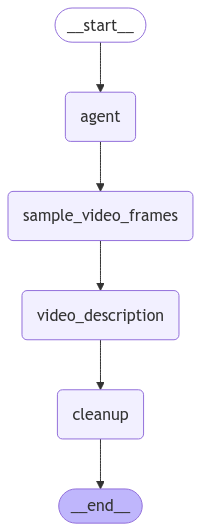

In [17]:
analyzer.show_graph()

---CALL AGENT---
{'sample_msec': 10000, 'resize_ratio': 0.7, 'sample_output_dir': './workspace'}
"\nOutput from node 'agent':"
'---'
{ 'analysis_config': { 'resize_ratio': 0.7,
                       'sample_msec': 10000,
                       'sample_output_dir': './workspace'},
  'video_path': './video/video_sample_2.mkv'}
'\n---\n'
---SAMPLE VIDEO FRAMES---
===sample_video_frames===
===setup_directory===
디렉토리 생성됨: ./workspace
진행률: 10.0%
진행률: 20.0%
진행률: 30.0%
진행률: 39.9%
진행률: 49.9%
진행률: 59.9%
진행률: 69.9%
진행률: 79.9%
진행률: 89.9%


INFO:retry-bedrock-invocation:trying frame_description() [1/5]



처리 완료:
총 프레임 수: 4677
프레임 크기: 448X336
샘플링된 프레임 수: 16
샘플링 간격: 303프레임 (10000ms)
저장 위치: ./workspace
Successfully saved to workspace/pickle/sampled_frames.pickle

elapsed time: node: sample_video_frames: 5.91542 초
"\nOutput from node 'sample_video_frames':"
'---'
{ 'video_info': { 'sampled_cnt': 16,
                  'sampled_frames_path': './workspace/pickle/sampled_frames.pickle',
                  'total_frame_cnt': 4677}}
'\n---\n'
---VIDEO DESCRIPTION---


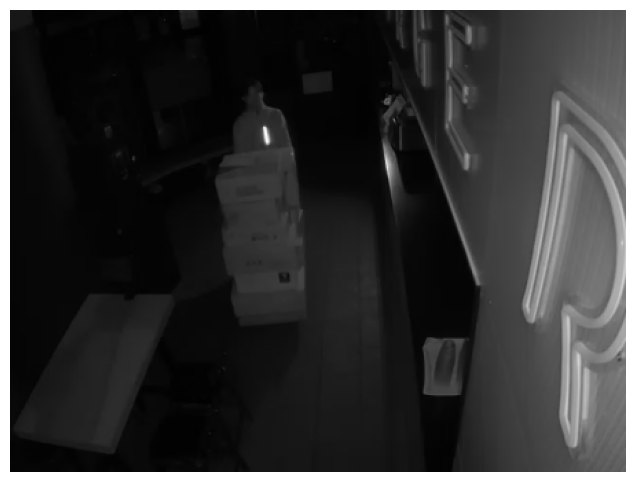


Role: assistant
{
    "scene_description": "현재 프레임에서는 한 명의 개인이 화면 중앙 부근에 위치하고 있으며, 밝은 조명을 휴대하고 있습니다. 이 개인은 상자와 같은 물체 앞에 서 있습니다.",
    "person_description": "개인은 밝은 조명을 휴대하고 있으며, 상자 앞에 서 있습니다. 구체적인 특징은 불분명합니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '현재 프레임에서는 한 명의 개인이 화면 중앙 부근에 위치하고 있으며, 밝은 조명을 휴대하고 있습니다. 이 개인은 상자와 같은 물체 앞에 서 있습니다.', 'person_description': '개인은 밝은 조명을 휴대하고 있으며, 상자 앞에 서 있습니다. 구체적인 특징은 불분명합니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2066
Output tokens: 160
Total tokens: 2226
Latency: 5254 milliseconds
total token usage: {'input': 2066, 'output': 160, 'total': 2226}


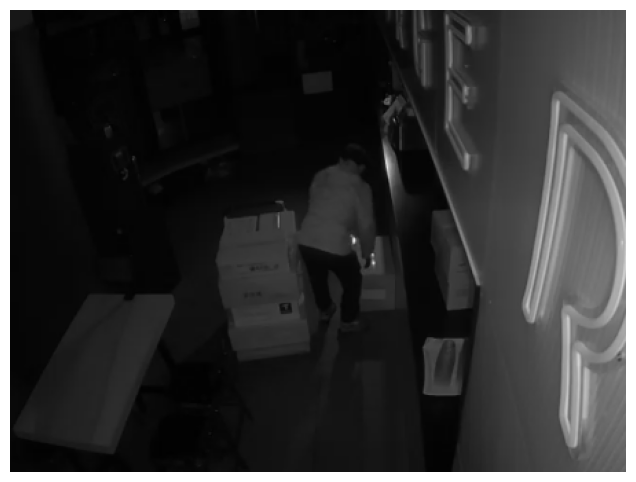


Role: assistant
{
    "scene_description": "한 사람이 어두운 복도에서 여러 개의 상자를 쌓아 놓은 곳 옆을 지나가고 있습니다. 그는 상자를 옮기는 동작을 하고 있으며, 상자 중 하나는 바닥에 놓여 있습니다. 그의 손에는 작은 물체를 들고 있는 것으로 보입니다.",
    "person_description": "사람은 밝은 색의 윗옷과 어두운 색의 바지를 입고 있으며, 머리는 짧게 자른 헤어스타일입니다. 그는 상자를 옮기는 동작을 하고 있으며, 손에 작은 물체를 들고 있습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '한 사람이 어두운 복도에서 여러 개의 상자를 쌓아 놓은 곳 옆을 지나가고 있습니다. 그는 상자를 옮기는 동작을 하고 있으며, 상자 중 하나는 바닥에 놓여 있습니다. 그의 손에는 작은 물체를 들고 있는 것으로 보입니다.', 'person_description': '사람은 밝은 색의 윗옷과 어두운 색의 바지를 입고 있으며, 머리는 짧게 자른 헤어스타일입니다. 그는 상자를 옮기는 동작을 하고 있으며, 손에 작은 물체를 들고 있습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2068
Output tokens: 255
Total tokens: 2323
Latency: 11497 milliseconds
total token usage: {'input': 4134, 'output': 415, 'total': 4549}


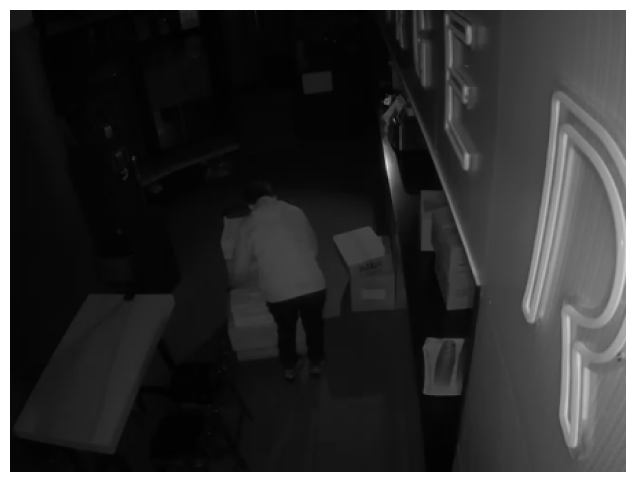


Role: assistant
{
    "scene_description": "한 사람이 복도를 따라 걸어가고 있으며, 손에 물건을 들고 있습니다. 주변에는 여러 상자들이 놓여 있습니다.",
    "person_description": "흰색 재킷과 어두운 색 바지를 입은 사람이 관찰됩니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '한 사람이 복도를 따라 걸어가고 있으며, 손에 물건을 들고 있습니다. 주변에는 여러 상자들이 놓여 있습니다.', 'person_description': '흰색 재킷과 어두운 색 바지를 입은 사람이 관찰됩니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2068
Output tokens: 120
Total tokens: 2188
Latency: 4245 milliseconds
total token usage: {'input': 6202, 'output': 535, 'total': 6737}


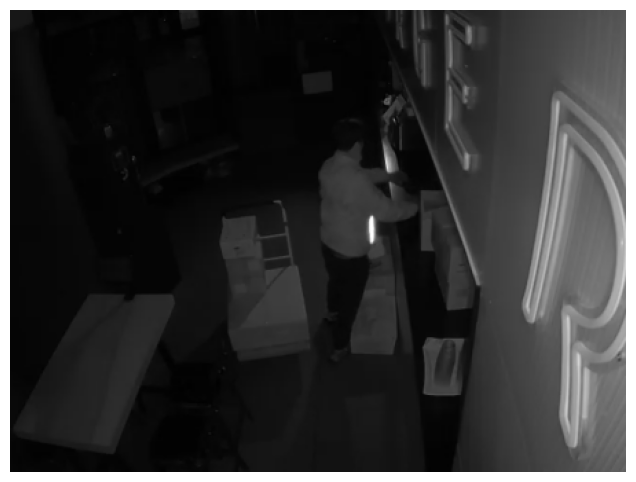


Role: assistant
{
    "scene_description": "한 사람이 어두운 실내에서 벽면의 선반에 물건을 올려놓고 있습니다. 그는 흰색 장판을 들고 있으며, 선반 옆에는 여러 개의 흰색 장판이 쌓여 있습니다. 그의 손에는 플래시라이트가 있어 주변을 밝히고 있습니다.",
    "person_description": "사람은 흰색 장판을 들고 있으며, 어두운 실내에서 플래시라이트를 사용하고 있습니다. 그는 긴 소매 셔츠와 검은색 바지를 입고 있습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '한 사람이 어두운 실내에서 벽면의 선반에 물건을 올려놓고 있습니다. 그는 흰색 장판을 들고 있으며, 선반 옆에는 여러 개의 흰색 장판이 쌓여 있습니다. 그의 손에는 플래시라이트가 있어 주변을 밝히고 있습니다.', 'person_description': '사람은 흰색 장판을 들고 있으며, 어두운 실내에서 플래시라이트를 사용하고 있습니다. 그는 긴 소매 셔츠와 검은색 바지를 입고 있습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2068
Output tokens: 235
Total tokens: 2303
Latency: 7192 milliseconds
total token usage: {'input': 8270, 'output': 770, 'total': 9040}


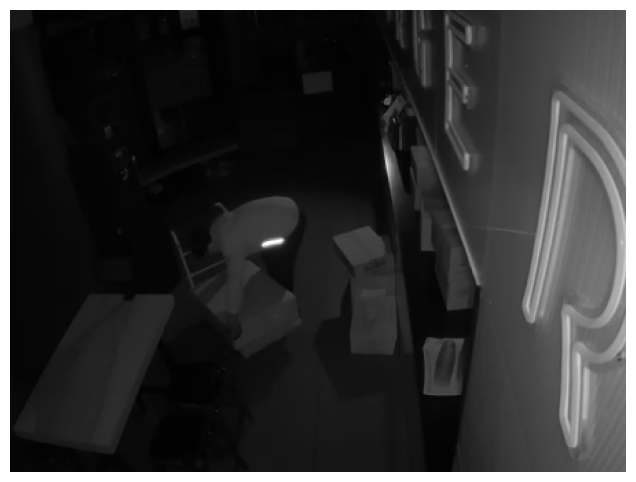


Role: assistant
{
    "scene_description": "현재 프레임에서는 어떠한 움직임도 관찰되지 않습니다. 모든 물체는 정지 상태로 보입니다.",
    "person_description": "현재 프레임에는 사람이 없습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '현재 프레임에서는 어떠한 움직임도 관찰되지 않습니다. 모든 물체는 정지 상태로 보입니다.', 'person_description': '현재 프레임에는 사람이 없습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2069
Output tokens: 88
Total tokens: 2157
Latency: 3433 milliseconds
total token usage: {'input': 10339, 'output': 858, 'total': 11197}


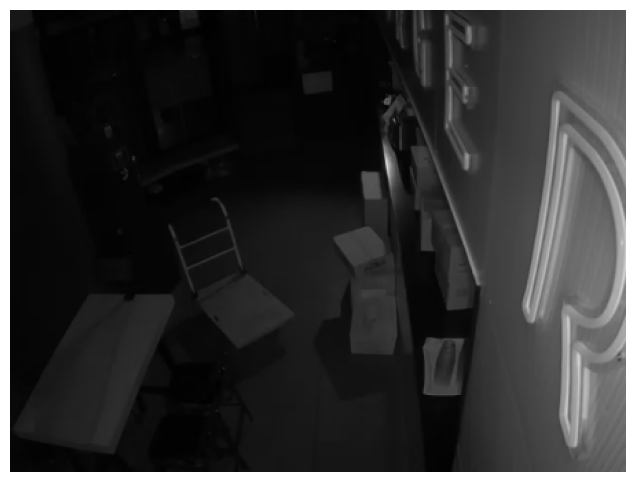


Role: assistant
{
    "scene_description": "현재 프레임에는 어두운 실내 공간이 보입니다. 왼쪽에는 접힌 채로 놓인 접이식 의자가 있으며, 바로 옆에는 탁자가 놓여 있습니다. 오른쪽에는 여러 개의 상자와 물건들이 쌓여 있고, 벽에는 큰 글자로 된 로고가 보입니다. 특별한 움직임이나 인물은 관찰되지 않습니다.",
    "person_description": "현재 프레임에는 인물이 관찰되지 않습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '현재 프레임에는 어두운 실내 공간이 보입니다. 왼쪽에는 접힌 채로 놓인 접이식 의자가 있으며, 바로 옆에는 탁자가 놓여 있습니다. 오른쪽에는 여러 개의 상자와 물건들이 쌓여 있고, 벽에는 큰 글자로 된 로고가 보입니다. 특별한 움직임이나 인물은 관찰되지 않습니다.', 'person_description': '현재 프레임에는 인물이 관찰되지 않습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2069
Output tokens: 217
Total tokens: 2286
Latency: 6910 milliseconds
total token usage: {'input': 12408, 'output': 1075, 'total': 13483}


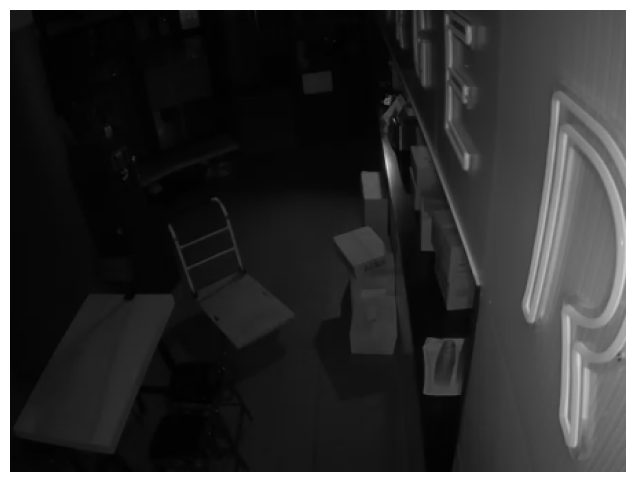


Role: assistant
{
    "scene_description": "현재 프레임에는 어두운 실내 공간이 보입니다. 왼쪽에는 의자와 테이블이 놓여 있고, 오른쪽에는 여러 개의 상자와 물건들이 쌓여 있습니다. 또한, 벽에는 큰 글자로 된 로고가 보입니다.",
    "person_description": "현재 프레임에는 사람이 보이지 않습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '현재 프레임에는 어두운 실내 공간이 보입니다. 왼쪽에는 의자와 테이블이 놓여 있고, 오른쪽에는 여러 개의 상자와 물건들이 쌓여 있습니다. 또한, 벽에는 큰 글자로 된 로고가 보입니다.', 'person_description': '현재 프레임에는 사람이 보이지 않습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2069
Output tokens: 157
Total tokens: 2226
Latency: 7525 milliseconds
total token usage: {'input': 14477, 'output': 1232, 'total': 15709}


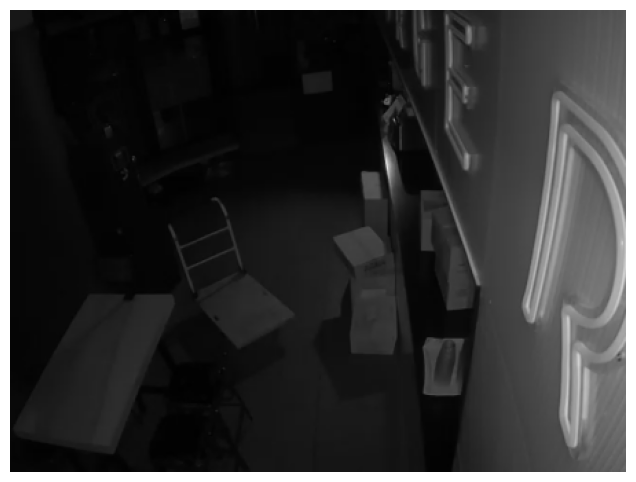


Role: assistant
{
    "scene_description": "현재 프레임에는 어두운 실내 공간이 보입니다. 왼쪽에는 접힌 책상과 의자가 바닥에 놓여 있으며, 오른쪽에는 여러 개의 상자와 물건들이 쌓여 있습니다. 또한, 벽에는 큰 글자로 된 표지판이 부착되어 있습니다.",
    "person_description": "현재 프레임에는 사람이 보이지 않습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '현재 프레임에는 어두운 실내 공간이 보입니다. 왼쪽에는 접힌 책상과 의자가 바닥에 놓여 있으며, 오른쪽에는 여러 개의 상자와 물건들이 쌓여 있습니다. 또한, 벽에는 큰 글자로 된 표지판이 부착되어 있습니다.', 'person_description': '현재 프레임에는 사람이 보이지 않습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2069
Output tokens: 176
Total tokens: 2245
Latency: 5781 milliseconds
total token usage: {'input': 16546, 'output': 1408, 'total': 17954}


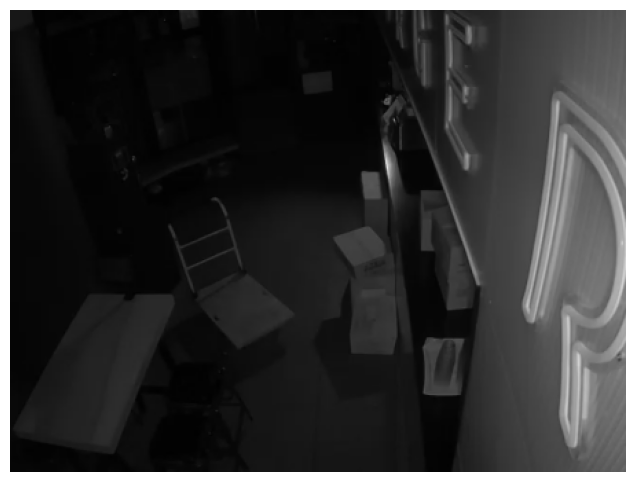


Role: assistant
{
    "scene_description": "현재 프레임에는 어두운 실내 공간이 보입니다. 왼쪽에는 접힌 채로 놓인 짐 트롤리가 있고, 그 옆에는 여러 개의 상자가 바닥에 무작위로 배치되어 있습니다. 오른쪽에는 벽에 밝은 글자가 보입니다.",
    "person_description": "현재 프레임에는 사람이 보이지 않습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '현재 프레임에는 어두운 실내 공간이 보입니다. 왼쪽에는 접힌 채로 놓인 짐 트롤리가 있고, 그 옆에는 여러 개의 상자가 바닥에 무작위로 배치되어 있습니다. 오른쪽에는 벽에 밝은 글자가 보입니다.', 'person_description': '현재 프레임에는 사람이 보이지 않습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2069
Output tokens: 169
Total tokens: 2238
Latency: 5638 milliseconds
total token usage: {'input': 18615, 'output': 1577, 'total': 20192}


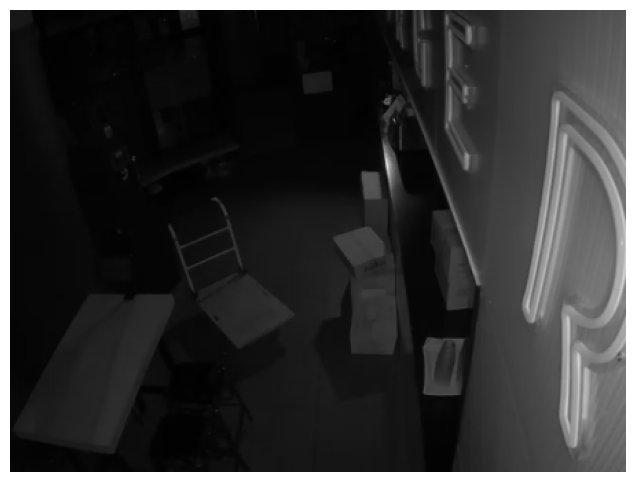


Role: assistant
{
    "scene_description": "현재 프레임에는 어두운 실내 공간이 보입니다. 왼쪽에는 접힌 책상과 의자가 놓여 있으며, 오른쪽에는 여러 개의 상자와 물건들이 쌓여 있습니다. 또한, 오른쪽 벽에는 큰 글자로 된 표지판이 부착되어 있습니다.",
    "person_description": "현재 프레임에는 사람이 보이지 않습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '현재 프레임에는 어두운 실내 공간이 보입니다. 왼쪽에는 접힌 책상과 의자가 놓여 있으며, 오른쪽에는 여러 개의 상자와 물건들이 쌓여 있습니다. 또한, 오른쪽 벽에는 큰 글자로 된 표지판이 부착되어 있습니다.', 'person_description': '현재 프레임에는 사람이 보이지 않습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2069
Output tokens: 178
Total tokens: 2247
Latency: 5694 milliseconds
total token usage: {'input': 20684, 'output': 1755, 'total': 22439}


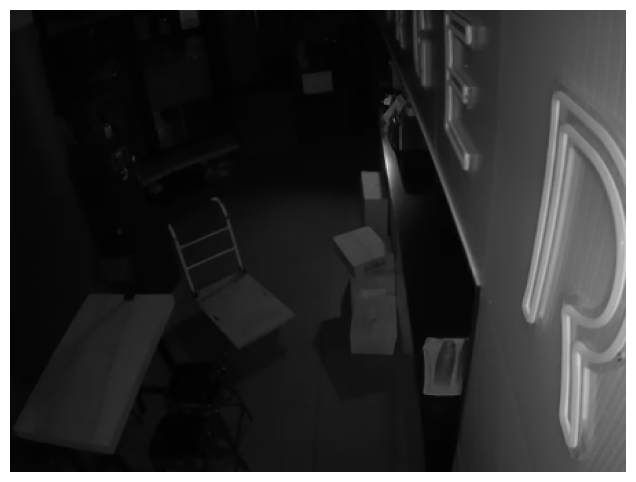


Role: assistant
{
    "scene_description": "현재 프레임에는 어두운 실내 공간이 보입니다. 왼쪽에는 의자와 테이블이 뒤집혀 있고, 오른쪽에는 여러 개의 상자와 물건들이 바닥에 놓여 있습니다. 또한, 벽에는 큰 글자로 된 표지판이 부착되어 있습니다.",
    "person_description": "현재 프레임에는 사람이 보이지 않습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '현재 프레임에는 어두운 실내 공간이 보입니다. 왼쪽에는 의자와 테이블이 뒤집혀 있고, 오른쪽에는 여러 개의 상자와 물건들이 바닥에 놓여 있습니다. 또한, 벽에는 큰 글자로 된 표지판이 부착되어 있습니다.', 'person_description': '현재 프레임에는 사람이 보이지 않습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2069
Output tokens: 176
Total tokens: 2245
Latency: 5599 milliseconds
total token usage: {'input': 22753, 'output': 1931, 'total': 24684}


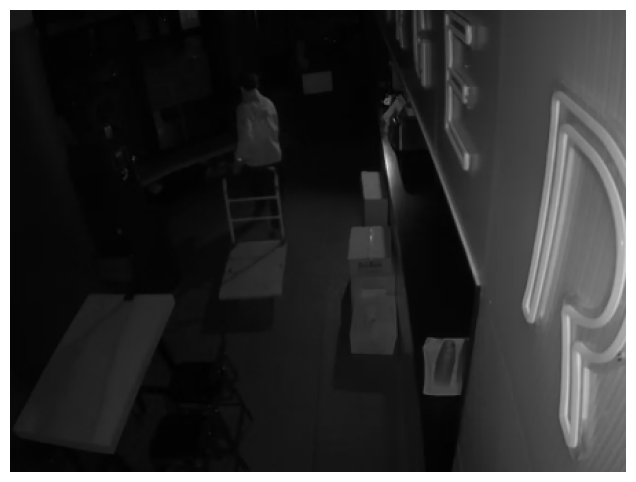


Role: assistant
{
    "scene_description": "사람 한 명이 현재 프레임에서 관찰되었습니다. 이 개인은 계단을 타고 내려오고 있으며, 어두운 환경에서 밝은 옷을 입고 있습니다. 그는 계단을 내려오는 동안 약간의 움직임을 보이고 있습니다.",
    "person_description": "밝은 색의 옷을 입은 개인이 관찰되었습니다. 이 개인은 계단을 타고 내려오고 있으며, 어두운 환경에서 눈에 띄는 존재입니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '사람 한 명이 현재 프레임에서 관찰되었습니다. 이 개인은 계단을 타고 내려오고 있으며, 어두운 환경에서 밝은 옷을 입고 있습니다. 그는 계단을 내려오는 동안 약간의 움직임을 보이고 있습니다.', 'person_description': '밝은 색의 옷을 입은 개인이 관찰되었습니다. 이 개인은 계단을 타고 내려오고 있으며, 어두운 환경에서 눈에 띄는 존재입니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2069
Output tokens: 203
Total tokens: 2272
Latency: 6417 milliseconds
total token usage: {'input': 24822, 'output': 2134, 'total': 26956}


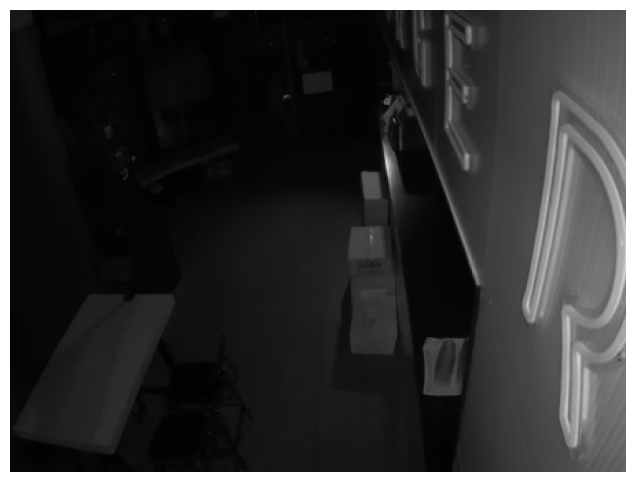


Role: assistant
{
    "scene_description": "현재 프레임에는 어두운 복도가 보입니다. 복도에는 여러 개의 상자가 쌓여 있으며, 벽에는 큰 글자로 'R'이 표시되어 있습니다. 특별한 움직임이나 인물은 관찰되지 않습니다.",
    "person_description": "현재 프레임에는 인물이 없습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': "현재 프레임에는 어두운 복도가 보입니다. 복도에는 여러 개의 상자가 쌓여 있으며, 벽에는 큰 글자로 'R'이 표시되어 있습니다. 특별한 움직임이나 인물은 관찰되지 않습니다.", 'person_description': '현재 프레임에는 인물이 없습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2069
Output tokens: 138
Total tokens: 2207
Latency: 4665 milliseconds
total token usage: {'input': 26891, 'output': 2272, 'total': 29163}


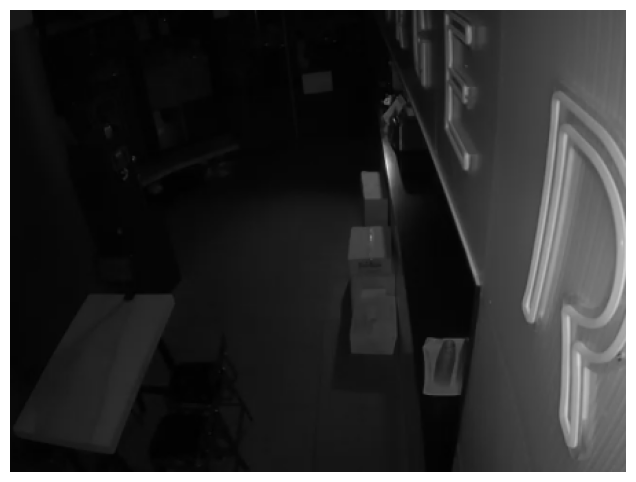


Role: assistant
{
    "scene_description": "현재 프레임에는 어두운 실내 공간이 보입니다. 특별한 움직임이나 활동은 관찰되지 않습니다. 프레임의 오른쪽에는 밝은 글자 'R'이 보입니다.",
    "person_description": "현재 프레임에는 사람이 관찰되지 않습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': "현재 프레임에는 어두운 실내 공간이 보입니다. 특별한 움직임이나 활동은 관찰되지 않습니다. 프레임의 오른쪽에는 밝은 글자 'R'이 보입니다.", 'person_description': '현재 프레임에는 사람이 관찰되지 않습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2069
Output tokens: 131
Total tokens: 2200
Latency: 4567 milliseconds
total token usage: {'input': 28960, 'output': 2403, 'total': 31363}


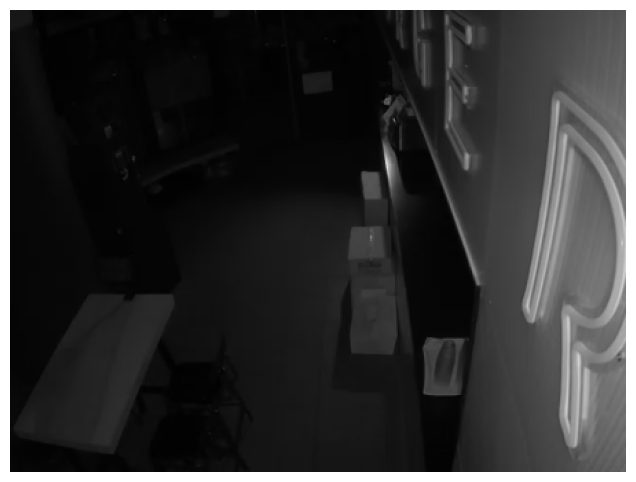


Role: assistant
{
    "scene_description": "현재 프레임에는 어두운 실내 공간이 보입니다. 특별한 움직임이나 활동은 관찰되지 않습니다. 프레임의 오른쪽에는 흰색 글자로 된 큰 'R' 문자가 벽에 표시되어 있습니다. 왼쪽에는 흰색 상자 몇 개가 바닥에 놓여 있습니다.",
    "person_description": "현재 프레임에는 사람이 관찰되지 않습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': "현재 프레임에는 어두운 실내 공간이 보입니다. 특별한 움직임이나 활동은 관찰되지 않습니다. 프레임의 오른쪽에는 흰색 글자로 된 큰 'R' 문자가 벽에 표시되어 있습니다. 왼쪽에는 흰색 상자 몇 개가 바닥에 놓여 있습니다.", 'person_description': '현재 프레임에는 사람이 관찰되지 않습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 2069
Output tokens: 191
Total tokens: 2260
Latency: 6035 milliseconds
total token usage: {'input': 31029, 'output': 2594, 'total': 33623}


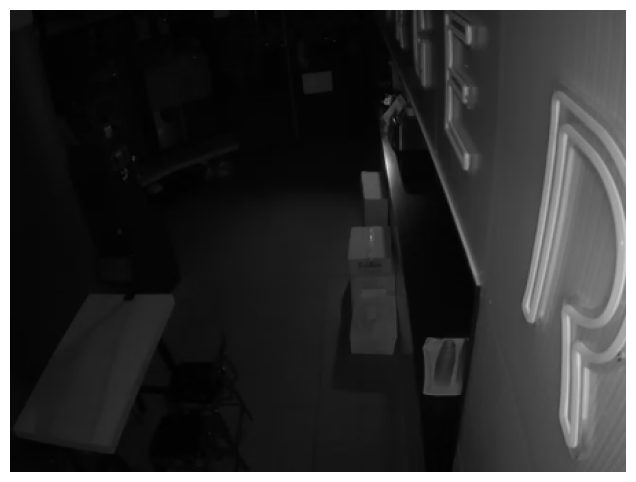


Role: assistant
{
    "scene_description": "현재 프레임에는 어두운 실내 공간이 보입니다. 특별한 움직임이나 활동은 관찰되지 않습니다. 프레임의 오른쪽에는 밝은 네온 조명이 보입니다.",
    "person_description": "현재 프레임에는 사람이 관찰되지 않습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '현재 프레임에는 어두운 실내 공간이 보입니다. 특별한 움직임이나 활동은 관찰되지 않습니다. 프레임의 오른쪽에는 밝은 네온 조명이 보입니다.', 'person_description': '현재 프레임에는 사람이 관찰되지 않습니다.'}'



Token usage
Input tokens: 2069
Output tokens: 133
Total tokens: 2202
Latency: 4598 milliseconds
total token usage: {'input': 33098, 'output': 2727, 'total': 35825}

Role: assistant
{
    "summary": "현재 분석된 영상 내에서는 주로 야간 시간대의 활동이 관찰되었습니다. 여러 개의 상자와 물건들이 다양한 위치에 놓여 있으며, 몇몇 개인들이 상자를 옮기거나 물건을 올려놓는 동작을 하고 있었습니다. 또한, 어두운 환경에서 밝은 조명을 사용하는 행동이 관찰되었습니다. 대부분의 프레임에서는 인물이 관찰되지 않았으며, 특정 구역에 'R' 문자가 표시되어 있는 것이 반복적으로 나타났습니다.",
    "key_events": [
        {
            "description": "개인이 밝은 조명을 사용하며 상자 앞에 서 있음",
            "significance": "MEDIUM"
        },
        {
            "description": "개인이 상자를 옮기는 동작을 함",
            "significance": "MEDIUM"
        },
        {
            "description": "개인이 어두운 실내에서 플래시라이트를 사용하며 물건을 올려놓음",
            "significance": "HIGH"
        },
        {
            "description": "개인이 계단을 타고 내려옴",
            "significance": "MEDIUM"
        }
    ],
    "objects_involved": {
        "items": [
            "상자",
            "플래시라이트",
            "흰색 장판",
      

In [18]:
analyzer.invoke(
    video_path="./video/video_sample_2.mkv",
    analysis_config={
        "sample_msec": 10000,
        "resize_ratio": 0.7,
        "sample_output_dir": "./workspace"
    }
)

- **approach 2**: n개 연속 프레임 제공 후 상황에 대한 desc를 생성, 생성된 desc를 모아서 요약하여 상황설명 한다.

In [30]:
class video_analyzer():

    def __init__(self, **kwargs):

        self.llm=kwargs["llm"]
        self.state = GraphState

        self.llm_caller = llm_call(
            llm=self.llm,
            verbose=True ## To show token usage
        ) 

        self._graph_definition()
        self.messages = []
        self.img_bytes = ""
        
        self.timer = TimeMeasurement()
        
    def _get_price(self, tokens):
        
        input_price = tokens["input"] * 0.0008 / 1000
        output_price = tokens["output"] * 0.0032 / 1000
        total = input_price + output_price
        
        print ("======= Cost Calculator =======")
        print (f'Token Usage, input: {tokens["input"]}, Output: {tokens["output"]}')
        print (f'Price: {total} USD')
        print ("===============================")
        
    def _get_string_from_message(self, message):
        return message["content"][0]["text"]
    
    def _get_message_from_string(self, role, string, imgs=None):
        
        message = {
            "role": role,
            "content": []
        }
        
        if imgs is not None:
            for img in imgs:
                img_message = {
                    "image": {
                        "format": 'png',
                        "source": {"bytes": img}
                    }
                }
                message["content"].append(img_message)
        
        message["content"].append({"text": dedent(string)})

        return message
    
    def _frame_to_bytes(self, frame, format='.png'):
        """
        cv2 frame을 bytes로 변환

        Args:
            frame: cv2로 읽은 이미지/프레임
            format: 이미지 포맷 (예: '.jpg', '.png')

        Returns:
            bytes: 이미지의 바이트 데이터
        """
        # imencode() 함수로 프레임을 지정된 포맷의 이미지로 인코딩
        # 반환값: (success, encoded_image)
        success, buffer = cv2.imencode(format, frame)

        if not success:
            raise ValueError("이미지 인코딩 실패")

        # numpy array를 bytes로 변환
        return buffer.tobytes()

    def _save_pickle(self, data: Any, file_path: str | Path) -> None:
        """
        데이터를 pickle 파일로 저장합니다.

        Args:
            data: 저장할 데이터 (Any type)
            file_path: 저장할 파일 경로 (확장자 .pkl 권장)
        """
        file_path = Path(file_path)

        # 디렉토리가 없으면 생성
        file_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            with open(file_path, 'wb') as f:
                pickle.dump(data, f)
            print(f"Successfully saved to {file_path}")
        except Exception as e:
            print(f"Error saving pickle file: {e}")

    def _load_pickle(self, file_path: str | Path) -> Any:
        """
        pickle 파일을 로드합니다.

        Args:
            file_path: 로드할 파일 경로

        Returns:
            저장된 데이터 객체

        Raises:
            FileNotFoundError: 파일이 존재하지 않을 경우
        """
        file_path = Path(file_path)

        if not file_path.exists():
            raise FileNotFoundError(f"No pickle file found at {file_path}")

        try:
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
            return data
        except Exception as e:
            print(f"Error loading pickle file: {e}")
            return None

    def get_messages(self, ):
        return self.messages
        
    def _graph_definition(self, **kwargs):
        
        def agent(state):
            
            self.timer.start()
            self.timer.reset()
            
            print("---CALL AGENT---")
            video_path = state["video_path"]
            analysis_config = state["analysis_config"]
            
            self.tokens = {"input": 0, "output": 0, "total": 0}
            self.pricing = {"input": 0, "output": 0}
            
            print (analysis_config)
 
            return self.state(
                video_path=video_path,
                analysis_config=analysis_config,
                rev_node="AGENT"
            )

        def sample_video_frames(state):
        
            def setup_directory(dir_path):
    
                print ("===setup_directory===")
                # 디렉토리가 존재하는지 확인
                if os.path.exists(dir_path):
                    # 존재하면 삭제
                    shutil.rmtree(dir_path)
                    print(f"기존 디렉토리 삭제됨: {dir_path}")

                # 디렉토리 생성
                os.makedirs(dir_path)
                print(f"디렉토리 생성됨: {dir_path}")
                print ("=====================")
    
            video_path = state["video_path"]
            sample_msec = state["analysis_config"]["sample_msec"]
            resize_ratio = state["analysis_config"]["resize_ratio"]
            sample_output_dir = state["analysis_config"]["sample_output_dir"]
            
            print("---SAMPLE VIDEO FRAMES---")
            """
            비디오에서 특정 시간 간격으로 프레임을 샘플링하는 함수

            Args:
                video_path (str): 비디오 파일 경로
                sample_msec (int): 샘플링 간격 (밀리초)
                sample_output_dir (Optional[str]): 프레임 저장 디렉토리. None이면 저장하지 않음

            Returns:
                Tuple[int, int]: (총 프레임 수, 샘플링된 프레임 수)

            Raises:
                FileNotFoundError: 비디오 파일이 없는 경우
                ValueError: 샘플링 간격이 잘못된 경우
            """
            # 입력값 검증
            if not os.path.exists(video_path):
                raise FileNotFoundError(f"비디오 파일을 찾을 수 없습니다: {video_path}")

            if sample_msec <= 0:
                raise ValueError("샘플링 간격은 0보다 커야 합니다")

            # 비디오 캡처 객체 생성
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                raise RuntimeError("비디오 파일을 열 수 없습니다")

            # 비디오 정보 가져오기
            fps = cap.get(cv2.CAP_PROP_FPS)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # 샘플링 간격(프레임 단위) 계산
            frame_interval = max(1, int(sample_msec / 1000 * fps))

            # 출력 디렉토리 생성 (지정된 경우)
            if sample_output_dir is not None:
                setup_directory(sample_output_dir)

            sampled_count = 0
            frame_count = 0
            sampled_frame = {"frame": [], "seq": []}

            while True:
                ret, frame = cap.read()
                if not ret: break
                
                if resize_ratio != 1: 
                    re_width, re_height = int(frame.shape[1]*resize_ratio), int(frame.shape[0]*resize_ratio)
                    frame = cv2.resize(frame, (re_width, re_height), interpolation=cv2.INTER_AREA)

                # frame_interval마다 프레임 처리
                if frame_count % frame_interval == 0:
                    if sample_output_dir is not None:
                        # 프레임 저장
                        frame_path = os.path.join(sample_output_dir, f"frame_{frame_count:06d}.jpg")
                        cv2.imwrite(frame_path, frame)
                    sampled_count += 1
                    sampled_frame["frame"].append(frame)
                    sampled_frame["seq"].append(frame_count)
                frame_count += 1

                # 진행상황 출력 (10% 단위)
                if frame_count % (total_frames // 10) == 0:
                    progress = (frame_count / total_frames) * 100
                    print(f"진행률: {progress:.1f}%")

            # 자원 해제
            cap.release()

            print(f"\n처리 완료:")
            print(f"총 프레임 수: {total_frames}")
            print(f"프레임 크기: {sampled_frame['frame'][0].shape[1]}X{sampled_frame['frame'][0].shape[0]}")
            print(f"샘플링된 프레임 수: {sampled_count}")
            print(f"샘플링 간격: {frame_interval}프레임 ({sample_msec}ms)")
            if sample_output_dir is not None:
                print(f"저장 위치: {sample_output_dir}")

            print ("=========================")
            
            sampled_frames_path = os.path.join(sample_output_dir, "pickle", "sampled_frames.pickle")
            self._save_pickle(sampled_frame, sampled_frames_path)
            
            video_info = {
                "sampled_frames_path": sampled_frames_path,
                "total_frame_cnt": total_frames,
                "sampled_cnt": sampled_count
            }
            
            self.timer.measure("node: sample_video_frames")
            self.timer.print_measurements()
            
            return self.state(
                video_info=video_info,
                rev_node="SAMPLE_VIDEO_FRAMES"
            )
        
        def video_description(state):
            
            @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(botocore.exceptions.EventStreamError))
            def frame_description(**kwargs):
    
                sampled_frame = kwargs["sampled_frame"]
                sampled_frame_idx = kwargs["sampled_frame_idx"]
                frame_batch_size = kwargs["frame_batch_size"]
                prev_frame_desc = kwargs.get("prev_frame_desc", "None")
                messages = kwargs["messages"]

                system_prompts = dedent(
                    '''
                    System:
                    1. You are a CCTV Video Analysis Expert specialized in analyzing sequences of surveillance footage frames and describing situations in natural language.
                    2. Your role is to observe multiple consecutive frames and provide comprehensive situation analysis while maintaining objectivity and focus on relevant activities.

                    Model Instructions:
                    - You MUST analyze frames chronologically 
                    - You MUST focus on task, movement and behavioral patterns
                    - You MUST write all descriptions in Korean
                    - You MUST highlight significant changes or anomalies
                    - DO NOT describe static objects or background elements
                    - DO NOT make subjective interpretations
                    - DO NOT focus on counting or identifying specific individuals
                    - DO NOT speculate about unclear situations

                    Input Format:
                    - frames: Array of consecutive CCTV frame images
                    - frame_count: Number of provided frames
                    - prev_frame_desc: Description of previous frame sequence

                    Output Schema:
                    {
                        "sequence_summary": string,  // Objective description of observed situation
                        "key_events": [
                            {
                                "frame_range": [start_frame, end_frame],
                                "event_description": string  // Description of significant event
                            }
                        ]
                    }

                    Analysis Guidelines:
                    1. Movement Tracking:
                       - Track continuous movement patterns
                       - Note entry/exit from frame
                       - Document significant position changes
                       - Identify reappearing subjects

                    2. Sequence Understanding:
                       - Review frames chronologically
                       - Consider previous sequence context
                       - Maintain continuity in descriptions
                       - Focus on action progression

                    3. Visual Quality Assessment:
                       - Report visual obstructions
                       - Note lighting conditions
                       - Mention quality limitations
                       - Identify unclear areas

                    4. Critical Observations:
                       - Highlight unusual activities
                       - Note behavioral anomalies
                       - Document significant changes
                       - Mark suspicious patterns

                    5. Behavioral Focus:
                       - Emphasize actions over identities
                       - Track behavioral patterns
                       - Note interactions
                       - Document activity sequences

                    Remember:
                    - Maintain chronological continuity
                    - Focus on observable actions
                    - Be objective and clear
                    - Highlight significant changes
                    - Note technical limitations
                    - Track subject reappearances

                    '''
                )
                user_prompts = dedent(
                    '''
                     Frame_count:
                    {frame_count}
                    Prev_frame_desc>
                    {prev_frame_desc}

                    '''
                )

                img_bytes = []
                for frame in sampled_frame:                    
                    img_bytes.append(self._frame_to_bytes(frame))
                
                system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)  

                context = {
                    "frame_count": sampled_frame_idx,
                    "prev_frame_desc": prev_frame_desc
                }
                user_prompts = user_prompts.format(**context)

                message = self._get_message_from_string(role="user", string=user_prompts, imgs=img_bytes)
                messages.append(message)
                
                # 이미지 표시
                num_frames = len(sampled_frames)
                num_cols = frame_batch_size # row에 몇개의 사진을 보이게 할 것 인가
                num_rows = (num_frames + num_cols - 1) // num_cols  # 올림 나눗셈

                # 전체 figure 크기 설정
                plt.figure(figsize=(4*num_cols, 4*num_rows))

                # 각 프레임을 subplot으로 표시
                for idx, frame in enumerate(sampled_frame):
                    plt.subplot(num_rows, num_cols, idx + 1)

                    # BGR to RGB 변환
                    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                    # 이미지 표시
                    plt.imshow(rgb_frame)
                    plt.title(f'Frame {idx+1}')
                    plt.axis('off')

                # subplot 간 간격 조정
                plt.tight_layout()
                plt.show()
                
                ## Call LLM
                resp, messages_updated = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
                messages = messages_updated
                results = eval(resp["text"])
                
                if self.llm_caller.verbose:
                    self.tokens["input"] += resp["token_usage"]["inputTokens"]
                    self.tokens["output"] += resp["token_usage"]["outputTokens"]
                    self.tokens["total"] += resp["token_usage"]["totalTokens"]
                    print (f'total token usage: {self.tokens}')    

                return results
            
            print("---VIDEO DESCRIPTION---")
            
            frame_batch_size = state["analysis_config"]["frame_numbers_at_one"] 
            sliding_interval = state["analysis_config"]["sliding_window_size"] 
            sampled_frames= self._load_pickle(state["video_info"]["sampled_frames_path"])
            total_frame_cnt=state["video_info"]["total_frame_cnt"]
            total_sample_frame_cnt = state["video_info"]["sampled_cnt"]
            messages=kwargs.get("messages", [])
            
            # 제약 조건 체크
            if frame_batch_size > total_sample_frame_cnt:
                raise ValueError("Window size cannot be larger than total frames")

            # 마지막 프레임까지 커버하기 위한 조건 체크
            remaining_frames = (total_sample_frame_cnt - frame_batch_size) % sliding_interval
            if remaining_frames != 0:
                print(f"Warning: Last {remaining_frames} frames might be skipped with current parameters")
                print(f"Recommended sliding_interval: {[i for i in range(1, frame_batch_size) if (total_sample_frame_cnt - frame_batch_size) % i == 0]}")
                #raise ValueError("In this settingm you could not use all frames. Read recommendations")

            # 마지막 시작점 계산
            last_start = total_sample_frame_cnt - frame_batch_size

            frame_desc = "None"
            frame_descs = []
            for i in range(0, last_start + 1, sliding_interval):
                # frame_batch_size 개의 연속된 프레임 슬라이스 추출
                sampled_frame_idx = sampled_frames["seq"][i:i+frame_batch_size]
                sampled_frame = sampled_frames["frame"][i:i+frame_batch_size]

                # 마지막 윈도우가 전체 프레임을 커버하지 못하는 경우, 마지막 윈도우 추가
                # if i + sliding_interval > last_start and i != last_start:
                #     sampled_frame_idx = sampled_frames["seq"][last_start:last_start+frame_batch_size]
                #     sampled_frame = sampled_frames["frame"][last_start:last_start+frame_batch_size]
                    #break

                res = frame_description(
                    sampled_frame=sampled_frame,
                    sampled_frame_idx=sampled_frame_idx,
                    frame_batch_size=frame_batch_size,
                    total_frame_cnt=total_frame_cnt,
                    frame_desc=frame_desc, 
                    messages=[]
                )

                frame_desc = res["sequence_summary"]
                frame_descs.append(res["sequence_summary"])


            system_prompts = dedent(
                '''
                System:
                1. You are a CCTV Surveillance Analysis Expert specialized in synthesizing frame-by-frame descriptions into comprehensive situational analysis.
                2. Your role is to analyze sequential frame descriptions, identify meaningful patterns, extract significant events, and assess security risks while maintaining privacy considerations.

                Model Instructions:
                1. Analysis Requirements:
                  - You MUST review frame descriptions chronologically
                  - You MUST identify and extract meaningful events
                  - You MUST write all content in Korean
                  - You MUST evaluate event significance based on security impact
                  - DO NOT include personally identifiable information
                  - DO NOT speculate about unclear situations
                  - DO NOT include routine movements as key events

                2. Event Assessment Criteria:
                  - Security risks and threats
                  - Abnormal behavior patterns
                  - Property/facility risks
                  - Pattern repetition
                  - Contextual significance

                Input Format:
                frame_descriptions: [
                   string  // Sequential frame descriptions
                ]

                Output Schema:
                {
                   "summary": string,  // Comprehensive situation analysis
                   "key_events": [
                       {
                           "description": string,  // Event description
                           "significance": "HIGH/MEDIUM/LOW"  // Event importance
                       }
                   ],
                   "objects_involved": {
                       "people": [string],  // Roles without specific identifiers
                       "items": [string]    // Key objects
                   },
                   "analysis": {
                       "pattern": string,   // Identified behavior patterns
                       "anomalies": [string], // Unusual activities
                       "risk_assessment": string  // Potential risk evaluation
                   }
                }

                Analysis Guidelines:
                1. Sequence Analysis:
                  - Review descriptions chronologically
                  - Verify sequence consistency
                  - Identify behavioral patterns
                  - Track subject continuity
                  - Note temporal relationships

                2. Event Prioritization:
                  - Focus on security-relevant events
                  - Evaluate behavior patterns
                  - Assess potential risks
                  - Exclude routine activities
                  - Identify repeated patterns

                3. Risk Assessment:
                  - Evaluate security implications
                  - Identify potential threats
                  - Assess pattern abnormalities
                  - Consider contextual factors
                  - Flag suspicious activities

                4. Pattern Recognition:
                  - Identify behavioral trends
                  - Note recurring events
                  - Track movement patterns
                  - Document unusual sequences
                  - Compare with normal activity

                Remember:
                - Maintain objectivity in analysis
                - Prioritize security and privacy
                - Focus on significant patterns
                - Exclude non-essential details
                - Report only observed facts
                - Consider full context
                - Flag potential security risks
                '''
            )
            user_prompts = dedent(
                '''
                Frame_descriptions:
                {frame_descriptions}

                '''
            )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)  

            context = {
                "frame_descriptions": str(frame_descs)
            }
            user_prompts = user_prompts.format(**context)

            message = self._get_message_from_string(role="user", string=user_prompts)
            messages.append(message)

            resp, messages_updated = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            messages = messages_updated
            results = eval(resp["text"])
            
            if self.llm_caller.verbose:
                self.tokens["input"] += resp["token_usage"]["inputTokens"]
                self.tokens["output"] += resp["token_usage"]["outputTokens"]
                self.tokens["total"] += resp["token_usage"]["totalTokens"]            
                self._get_price(self.tokens)
            
            self.timer.measure("node: video_description")
            self.timer.print_measurements()
            
            return self.state(
                summary=results,
                rev_node="VIDEO_DESCRIPTION"
            )
        
        def cleanup(state):
                        
            print("---CLEAN UP---")
            analysis_config = state["analysis_config"]
            
            sample_output_dir = state["analysis_config"]["sample_output_dir"]
            
            if os.path.exists(sample_output_dir):
                # 존재하면 삭제
                shutil.rmtree(sample_output_dir)
                print(f"디렉토리 삭제됨: {sample_output_dir}")
                        
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("agent", agent)  # 에이전트 노드를 추가합니다.
        workflow.add_node("sample_video_frames", sample_video_frames)  # 비디오를 샘플링하여 프레임(이미지)변환 노드를 추가합니다.
        workflow.add_node("video_description", video_description)  # 비디오 영상 설명 노드를 추가합니다.
        workflow.add_node("cleanup", cleanup)  # 정리 노드를 추가합니다.

        workflow.add_edge("agent", "sample_video_frames")
        workflow.add_edge("sample_video_frames", "video_description")
        workflow.add_edge("video_description", "cleanup")
        workflow.add_edge("cleanup", END)

        # 시작점을 설정합니다.
        workflow.set_entry_point("agent")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "VideoAnalysis"})

    def invoke(self, **kwargs):
        
        inputs = self.state(
            video_path=kwargs["video_path"],
            analysis_config=kwargs["analysis_config"]
        )
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint(f"\nOutput from node '{key}':")
                pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint(value, indent=2, width=80, depth=None)
            # 각 출력 사이에 구분선을 추가합니다.
            pprint("\n---\n")
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

            

In [31]:
analyzer = video_analyzer(
    llm=llm
)

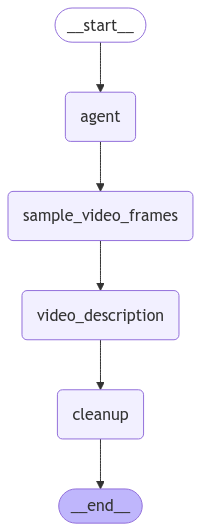

In [32]:
analyzer.show_graph()

---CALL AGENT---
{'sample_msec': 10000, 'resize_ratio': 0.7, 'frame_numbers_at_one': 7, 'sliding_window_size': 7, 'sample_output_dir': './workspace'}
"\nOutput from node 'agent':"
'---'
{ 'analysis_config': { 'frame_numbers_at_one': 7,
                       'resize_ratio': 0.7,
                       'sample_msec': 10000,
                       'sample_output_dir': './workspace',
                       'sliding_window_size': 7},
  'video_path': './video/video_sample_2.mkv'}
'\n---\n'
---SAMPLE VIDEO FRAMES---
===setup_directory===
기존 디렉토리 삭제됨: ./workspace
디렉토리 생성됨: ./workspace
진행률: 10.0%
진행률: 20.0%
진행률: 30.0%
진행률: 39.9%
진행률: 49.9%
진행률: 59.9%
진행률: 69.9%
진행률: 79.9%
진행률: 89.9%


INFO:retry-bedrock-invocation:trying frame_description() [1/5]



처리 완료:
총 프레임 수: 4677
프레임 크기: 448X336
샘플링된 프레임 수: 16
샘플링 간격: 303프레임 (10000ms)
저장 위치: ./workspace
Successfully saved to workspace/pickle/sampled_frames.pickle

elapsed time: node: sample_video_frames: 6.23532 초
"\nOutput from node 'sample_video_frames':"
'---'
{ 'video_info': { 'sampled_cnt': 16,
                  'sampled_frames_path': './workspace/pickle/sampled_frames.pickle',
                  'total_frame_cnt': 4677}}
'\n---\n'
---VIDEO DESCRIPTION---
Recommended sliding_interval: [1, 3]


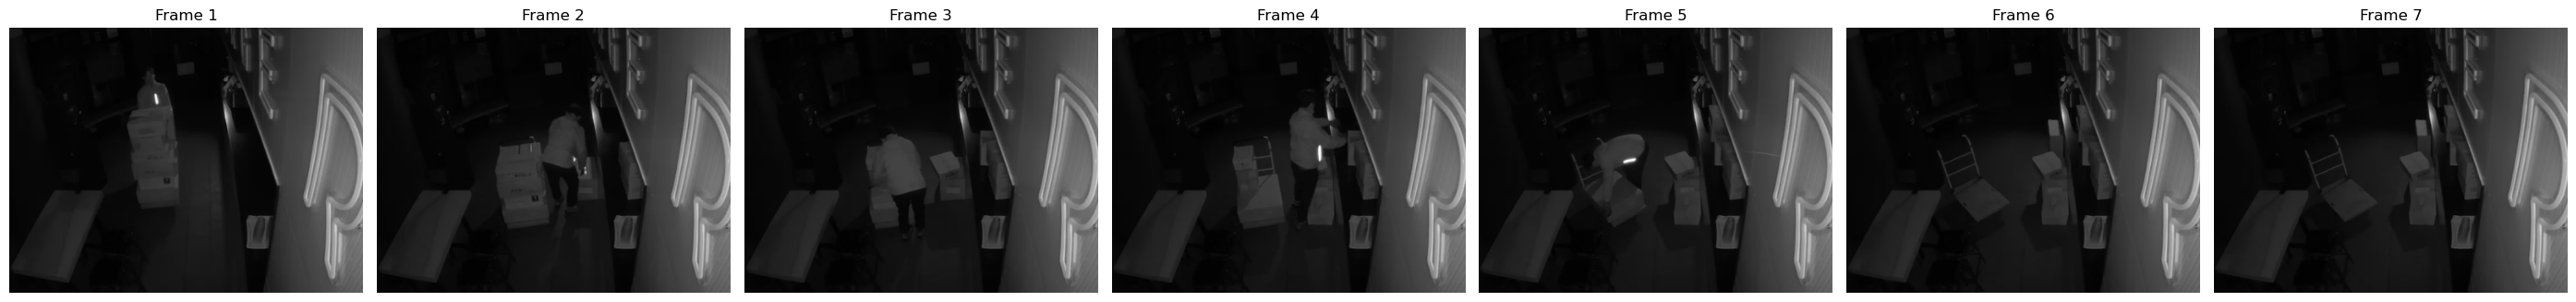


Role: assistant
{
    "sequence_summary": "관찰된 영상에서 한 개인이 상자를 옮기는 작업을 하고 있습니다. 개인은 처음에 상자를 쌓아놓은 후, 일부 상자를 다른 위치로 이동시키고 있습니다. 작업 도중 개인은 트롤리를 사용하여 상자를 운반하고 있으며, 일부 상자는 벽면에 배치되어 있습니다.",
    "key_events": [
        {
            "frame_range": [0, 303],
            "event_description": "개인이 상자를 쌓아놓는 작업을 시작합니다."
        },
        {
            "frame_range": [303, 606],
            "event_description": "개인이 일부 상자를 다른 위치로 이동시킵니다."
        },
        {
            "frame_range": [606, 909],
            "event_description": "개인이 트롤리를 사용하여 상자를 운반합니다."
        },
        {
            "frame_range": [909, 1212],
            "event_description": "개인이 상자를 벽면에 배치합니다."
        },
        {
            "frame_range": [1212, 1515],
            "event_description": "개인이 상자 배치를 조정합니다."
        },
        {
            "frame_range": [1515, 1818],
            "event_description": "개인이 상자 운반을 완료하고 트롤리를 내려놓습니다."
        }
    ]
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'sequence_summary': '관찰된 영상에서 한 개인이 상자를 옮기는 작업을 하고 있습니다. 개인은 처음에 상자를 쌓아놓은 후, 일부 상자를 다른 위치로 이동시키고 있습니다. 작업 도중 개인은 트롤리를 사용하여 상자를 운반하고 있으며, 일부 상자는 벽면에 배치되어 있습니다.', 'key_events': [{'frame_range': [0, 303], 'event_description': '개인이 상자를 쌓아놓는 작업을 시작합니다.'}, {'frame_range': [303, 606], 'event_description': '개인이 일부 상자를 다른 위치로 이동시킵니다.'}, {'frame_range': [606, 909], 'event_description': '개인이 트롤리를 사용하여 상자를 운반합니다.'}, {'frame_range': [909, 1212], 'event_description': '개인이 상자를 벽면에 배치합니다.'}, {'frame_range': [1212, 1515], 'event_description': '개인이 상자 배치를 조정합니다.'}, {'frame_range': [1515, 1818], 'event_description': '개인이 상자 운반을 완료하고 트롤리를 내려놓습니다.'}]}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 12124
Output tokens: 473
Total tokens: 12597
Latency: 16825 milliseconds
total token usage: {'input': 12124, 'output': 473, 'total': 12597}


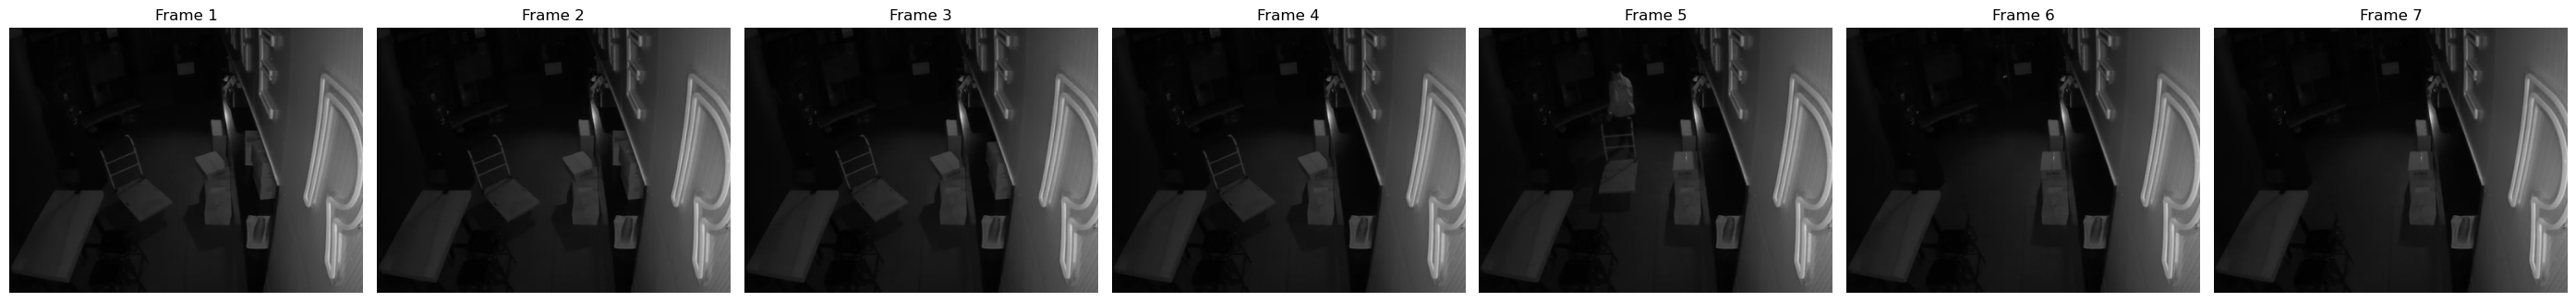


Role: assistant
{
    "sequence_summary": "전체 시퀀스에서 특별한 활동이나 움직임은 관찰되지 않았습니다. 모든 프레임에서 동일한 정적 장면이 나타납니다.",
    "key_events": [
        {
            "frame_range": [3333, 3636],
            "event_description": "사다리를 타고 들어오는 인물이 관찰되었습니다."
        }
    ]
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'sequence_summary': '전체 시퀀스에서 특별한 활동이나 움직임은 관찰되지 않았습니다. 모든 프레임에서 동일한 정적 장면이 나타납니다.', 'key_events': [{'frame_range': [3333, 3636], 'event_description': '사다리를 타고 들어오는 인물이 관찰되었습니다.'}]}'



Token usage
Input tokens: 12130
Output tokens: 147
Total tokens: 12277
Latency: 7210 milliseconds
total token usage: {'input': 24254, 'output': 620, 'total': 24874}

Role: assistant
{
   "summary": "관찰된 영상에서 한 개인이 상자를 옮기는 작업을 하고 있으며, 트롤리를 사용하여 상자를 운반하고 있습니다. 전체 시퀀스에서 특별한 활동이나 움직임은 관찰되지 않았으며, 모든 프레임에서 동일한 정적 장면이 나타납니다.",
   "key_events": [
       {
           "description": "한 개인이 상자를 옮기는 작업을 하고 있습니다.",
           "significance": "MEDIUM"
       },
       {
           "description": "개인이 트롤리를 사용하여 상자를 운반하고 있습니다.",
           "significance": "MEDIUM"
       }
   ],
   "objects_involved": {
       "people": ["개인"],
       "items": ["상자", "트롤리"]
   },
   "analysis": {
       "pattern": "개인이 상자를 옮기는 작업을 하고 있으며, 트롤리를 사용하여 상자를 운반하고 있습니다.",
       "anomalies": [],
       "risk_assessment": "현재 관찰된 활동은 특별한 보안 위험을 나타내지 않습니다. 그러나 상자의 이동 과정에서 벽면에 배치된 상자가 안전하게 고정되어 있는지 확인할 필요가 있습니다."
   }
}
Token usage
Input tokens: 744
Output tokens: 435
Total tokens: 1179
Latency: 6103 milliseconds
======= Cost 

In [33]:
analyzer.invoke(
    video_path="./video/video_sample_2.mkv",
    analysis_config={
        "sample_msec": 10000,
        "resize_ratio": 0.7,
        "frame_numbers_at_one": 7,
        "sliding_window_size": 7,
        "sample_output_dir": "./workspace"
    }
)


In [ ]:
import cv2
import matplotlib.pyplot as plt

- cv2.CAP_PROP_FPS: 초당 프레임 수
- cv2.CAP_PROP_FRAME_COUNT: 총 프레임 수
- cv2.CAP_PROP_FRAME_WIDTH: 프레임 너비
- cv2.CAP_PROP_FRAME_HEIGHT: 프레임 높이
- cv2.CAP_PROP_POS_FRAMES: 현재 프레임 번호
- cv2.CAP_PROP_POS_MSEC: 현재 위치(밀리초)
- cv2.CAP_PROP_FOURCC: 비디오 코덱
- cv2.CAP_PROP_BRIGHTNESS: 밝기
- cv2.CAP_PROP_CONTRAST: 대비